In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_json('news_dataset.json')
df.head()


,text,category
0,Watching Schrödinger's Cat Die University of C...,SCIENCE
1,WATCH: Freaky Vortex Opens Up In Flooded Lake,SCIENCE
2,Entrepreneurs Today Don't Need a Big Budget to...,BUSINESS
3,These Roads Could Recharge Your Electric Car A...,BUSINESS
4,Civilian 'Guard' Fires Gun While 'Protecting' ...,CRIME


In [4]:
print(df.shape)

print(df.category.value_counts())

(12695, 2)
BUSINESS    4254
SPORTS      4167
CRIME       2893
SCIENCE     1381
Name: category, dtype: int64


In [5]:
## Downsampling the data

df_bus = df[df['category'] == 'BUSINESS'].sample(1381)
df_sports = df[df['category'] == 'SPORTS'].sample(1381)
df_crime = df[df['category'] == 'CRIME'].sample(1381)
df_science = df[df['category'] == 'SCIENCE'].sample(1381)

df_new = pd.concat([df_bus,df_sports,df_crime,df_science])

df_new.category.value_counts()



SPORTS      1381
SCIENCE     1381
BUSINESS    1381
CRIME       1381
Name: category, dtype: int64

In [7]:
import spacy
nlp = spacy.load('en_core_web_lg')

## Creating a function to preprocess the data/text
def text_prep(text):
    doc = nlp(text)
    filtered_token = []
    for token in doc:
        if not token.is_stop | token.is_punct:
            filtered_token.append(token.lemma_)
    return ' '.join(filtered_token)



df_new['prep_text'] = df_new['text'].apply(text_prep)

df_new.head()


,text,category,prep_text
3066,10 Ways to Spot a Truly Exceptional Employee D...,BUSINESS,10 way spot Truly Exceptional employee deal di...
5342,Trump Even Found A Way To Make His Charity Eff...,BUSINESS,Trump find way charity Efforts bad far generou...
10258,What Type Of Pot Smoker Are You?,BUSINESS,type Pot Smoker
7167,Coloring Outside the Lines I had dinner with m...,BUSINESS,color outside line dinner brother family day r...
3771,Tesla's Self-Driving Feature Has Regulators Sc...,BUSINESS,Tesla self drive feature regulator scramble


In [8]:
#Creating vectors from Spacy for the prep_text column

df_new['vectors'] = df_new['prep_text'].apply(lambda x: nlp(x).vector)

labels = {'BUSINESS':0, 'SCIENCE':1,'SPORTS':2,'CRIME':3}

df_new['cat_num'] = df_new['category'].map(labels)

df_new.tail()

,text,category,prep_text,vectors,cat_num
2014,Teaching Robots To Be Moral,SCIENCE,teach robot moral,"[-0.1611783, 1.31393, -1.1785634, -0.92167664,...",1
7082,Scientists May One Day Treat Schizophrenia By ...,SCIENCE,scientist day treat Schizophrenia target Brain...,"[0.21183836, 1.3618196, -1.0549275, -0.5254693...",1
6571,Here's Where To Marvel At The 'Blood Moon',SCIENCE,Marvel Blood Moon,"[-1.3075166, 0.5978, 0.10414664, 0.07786667, 1...",1
9849,Homo Naledi may be Two Million Years Old (Give...,SCIENCE,Homo Naledi million year Old global interest a...,"[-0.41448265, -0.65241593, 1.6636497, -1.30620...",1
4127,Kalevi Kull: Censorship & Royal Society Evo Ev...,SCIENCE,Kalevi Kull Censorship Royal Society Evo Event,"[-1.3300171, -1.3360201, 1.6599042, 1.0000185,...",1


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train,X_test,y_train,y_test = train_test_split(df_new.vectors.values,
                                                df_new.cat_num,
                                                test_size = 0.2,
                                                random_state=101,
                                                stratify=df_new.cat_num)

X_train_2D = np.stack(X_train)
X_test_2D = np.stack(X_test)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_2D)
X_test_scaled = scaler.transform(X_test_2D)

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

clf = DecisionTreeClassifier()
clf.fit(X_train_scaled,y_train)

y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.56      0.56      0.56       276
           1       0.59      0.62      0.61       276
           2       0.61      0.62      0.62       276
           3       0.65      0.61      0.63       277

    accuracy                           0.60      1105
   macro avg       0.61      0.60      0.60      1105
weighted avg       0.61      0.60      0.60      1105



In [15]:
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train_scaled,y_train)

y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.69      0.75      0.72       276
           1       0.73      0.70      0.72       276
           2       0.75      0.74      0.75       276
           3       0.83      0.81      0.82       277

    accuracy                           0.75      1105
   macro avg       0.75      0.75      0.75      1105
weighted avg       0.75      0.75      0.75      1105



In [16]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
clf.fit(X_train_scaled,y_train)

y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.72      0.83      0.77       276
           1       0.80      0.72      0.76       276
           2       0.86      0.71      0.78       276
           3       0.75      0.84      0.79       277

    accuracy                           0.78      1105
   macro avg       0.78      0.78      0.78      1105
weighted avg       0.78      0.78      0.78      1105



In [17]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train_scaled,y_train)

y_pred = clf.predict(X_test_scaled)

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.83      0.80       276
           1       0.78      0.82      0.80       276
           2       0.87      0.77      0.82       276
           3       0.85      0.84      0.84       277

    accuracy                           0.81      1105
   macro avg       0.82      0.81      0.81      1105
weighted avg       0.82      0.81      0.81      1105



In [19]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test,y_pred)

Text(69.0, 0.5, 'Truth')

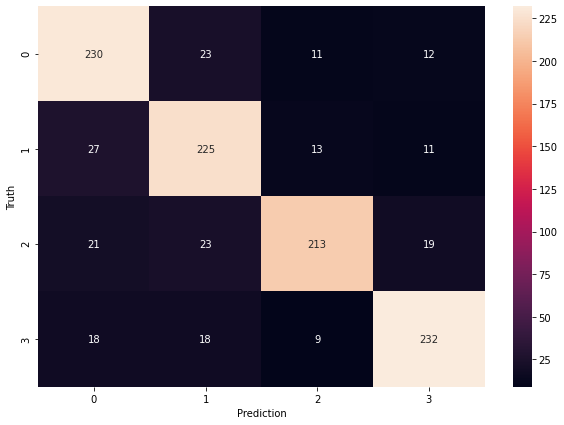

In [20]:
from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize = (10,7))
sn.heatmap(cm,annot = True, fmt = 'd')
plt.xlabel('Prediction')
plt.ylabel('Truth')